## Time Series Forecasting with XGBoost

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
df_0 = pd.read_csv('./data/7832_battery.csv')
df_0.head()

,v_bat,battery_soc,temperature,box_id,event_time
0,70.92,58.43,34.59,7832,2024-11-06 14:01:41
1,70.92,58.43,34.59,7832,2024-11-06 14:01:41
2,70.92,58.43,34.59,7832,2024-11-06 14:01:41
3,70.92,58.43,34.59,7832,2024-11-06 14:01:41
4,70.92,58.50,34.56,7832,2024-11-06 14:00:42


In [3]:
df_0['box_id'].unique()

array([7832])

In [4]:
df_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26584 entries, 0 to 26583
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   v_bat        26584 non-null  float64
 1   battery_soc  26584 non-null  float64
 2   temperature  26584 non-null  float64
 3   box_id       26584 non-null  int64  
 4   event_time   26584 non-null  object 
dtypes: float64(3), int64(1), object(1)
memory usage: 1.0+ MB


In [5]:
df_0.describe()

,v_bat,battery_soc,temperature,box_id
count,26584.000000,26584.000000,26584.000000,26584.0
mean,81.014837,73.127283,34.311100,7832.0
std,11.054354,22.020947,3.544261,0.0
min,54.420000,3.630000,27.860000,7832.0
25%,73.170000,62.562500,32.110000,7832.0
50%,81.250000,76.905000,34.240000,7832.0
75%,90.170000,91.180000,36.112500,7832.0
max,98.500000,100.000000,48.620000,7832.0


In [6]:
df_0.isna().sum()

v_bat          0
battery_soc    0
temperature    0
box_id         0
event_time     0
dtype: int64

In [7]:
# df_0[['v_bat', 'battery_soc', 'temperature']].ffill(inplace=True)
# data.fillna({'v_bat': 'ffill', 'battery_soc': 'ffill', 'temperature': 'ffill'}, inplace=True)

In [8]:
def calculate_vol(v_bat):
    return (((v_bat/100) * 1200) + 3000)/1000

def calculate_soc(Vnormalized):
    return 112 - 112/(1 + ((1.9*Vnormalized)**2.9))

def calculate_soc_2(Vnormalized):
    return 270 - 270/((1 + ((3.5 * Vnormalized)**8))**0.045)

def normalize(voltage):
    return (voltage - min_vol) / (max_vol - min_vol)

max_vol = 4.2
min_vol = 3

df = (df_0
      .assign(vol=lambda x: x['v_bat'].apply(calculate_vol))
      .assign(Vnormalized=lambda x: x['vol'].apply(normalize))
      .assign(soc=lambda x: x['Vnormalized'].apply(calculate_soc))
      .assign(soc_2=lambda x: x['Vnormalized'].apply(calculate_soc_2)))
df.head()

,v_bat,battery_soc,temperature,box_id,event_time,vol,Vnormalized,soc,soc_2
0,70.92,58.43,34.59,7832,2024-11-06 14:01:41,3.85104,0.7092,78.812187,75.370364
1,70.92,58.43,34.59,7832,2024-11-06 14:01:41,3.85104,0.7092,78.812187,75.370364
2,70.92,58.43,34.59,7832,2024-11-06 14:01:41,3.85104,0.7092,78.812187,75.370364
3,70.92,58.43,34.59,7832,2024-11-06 14:01:41,3.85104,0.7092,78.812187,75.370364
4,70.92,58.50,34.56,7832,2024-11-06 14:00:42,3.85104,0.7092,78.812187,75.370364


In [9]:
df.isna().sum()

v_bat          0
battery_soc    0
temperature    0
box_id         0
event_time     0
vol            0
Vnormalized    0
soc            0
soc_2          0
dtype: int64

In [10]:
df = df.set_index('event_time')
df.head()

,v_bat,battery_soc,temperature,box_id,vol,Vnormalized,soc,soc_2
event_time,,,,,,,,
2024-11-06 14:01:41,70.92,58.43,34.59,7832,3.85104,0.7092,78.812187,75.370364
2024-11-06 14:01:41,70.92,58.43,34.59,7832,3.85104,0.7092,78.812187,75.370364
2024-11-06 14:01:41,70.92,58.43,34.59,7832,3.85104,0.7092,78.812187,75.370364
2024-11-06 14:01:41,70.92,58.43,34.59,7832,3.85104,0.7092,78.812187,75.370364
2024-11-06 14:00:42,70.92,58.50,34.56,7832,3.85104,0.7092,78.812187,75.370364


In [11]:
df = df[['box_id', 'temperature', 'vol', 'battery_soc', 'soc', 'soc_2']]

In [11]:
df.head()

,v_bat,battery_soc,temperature,box_id,vol,Vnormalized,soc,soc_2
event_time,,,,,,,,
2024-11-06 14:01:41,70.92,58.43,34.59,7832,3.85104,0.7092,78.812187,75.370364
2024-11-06 14:01:41,70.92,58.43,34.59,7832,3.85104,0.7092,78.812187,75.370364
2024-11-06 14:01:41,70.92,58.43,34.59,7832,3.85104,0.7092,78.812187,75.370364
2024-11-06 14:01:41,70.92,58.43,34.59,7832,3.85104,0.7092,78.812187,75.370364
2024-11-06 14:00:42,70.92,58.50,34.56,7832,3.85104,0.7092,78.812187,75.370364


In [13]:
df.isna().sum()

box_id         0
temperature    0
vol            0
battery_soc    0
soc            0
soc_2          0
dtype: int64

In [12]:
df.index = pd.to_datetime(df.index)
# df.sort_values('event_time', ascending=True)
df.sort_index(inplace=True)
df.head()

,v_bat,battery_soc,temperature,box_id,vol,Vnormalized,soc,soc_2
event_time,,,,,,,,
2024-11-02 13:34:10,80.0,64.33,31.28,7832,3.96,0.8,86.357805,83.627556
2024-11-02 13:34:20,80.0,64.33,31.28,7832,3.96,0.8,86.357805,83.627556
2024-11-02 13:34:23,80.0,64.33,31.28,7832,3.96,0.8,86.357805,83.627556
2024-11-02 13:34:23,80.0,64.33,31.28,7832,3.96,0.8,86.357805,83.627556
2024-11-02 13:34:23,80.0,64.33,31.28,7832,3.96,0.8,86.357805,83.627556


In [15]:
df.isna().sum()

box_id         0
temperature    0
vol            0
battery_soc    0
soc            0
soc_2          0
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26584 entries, 2024-11-02 13:34:10 to 2024-11-06 14:01:41
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   v_bat        26584 non-null  float64
 1   battery_soc  26584 non-null  float64
 2   temperature  26584 non-null  float64
 3   box_id       26584 non-null  int64  
 4   vol          26584 non-null  float64
 5   Vnormalized  26584 non-null  float64
 6   soc          26584 non-null  float64
 7   soc_2        26584 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 1.8 MB


In [17]:
df.describe()

,box_id,temperature,vol,battery_soc,soc,soc_2
count,26584.0,26584.000000,26584.000000,26584.000000,26584.000000,26584.000000
mean,7832.0,34.311100,3.972178,73.127283,85.656237,83.572387
std,0.0,3.544261,0.132652,22.020947,8.588300,9.669092
min,7832.0,27.860000,3.653040,3.630000,58.711212,55.950755
25%,7832.0,32.110000,3.878040,62.562500,80.887748,77.545173
50%,7832.0,34.240000,3.975000,76.905000,87.235923,84.664640
75%,7832.0,36.112500,4.082040,91.180000,92.572514,91.484908
max,7832.0,48.620000,4.182000,100.000000,96.350407,97.073622


In [14]:
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=['#cc444b', '#e89005'])

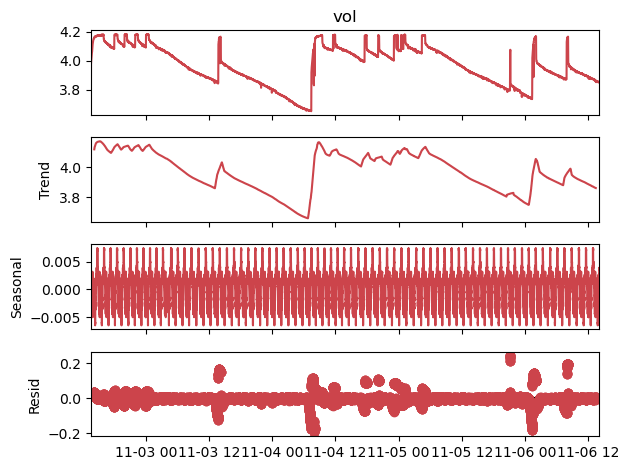

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(df['vol'], period=365).plot()
plt.show()

In [16]:
# seasonal_decompose(df['soc'], period=365).plot()
# plt.show()

In [17]:
# df.plot(figsize=(20,8))
# plt.title('Voltage', weight='bold', fontsize=25)

In [18]:
va = df.resample('T').mean()
va.head()

,v_bat,battery_soc,temperature,box_id,vol,Vnormalized,soc,soc_2
event_time,,,,,,,,
2024-11-02 13:34:00,80.000000,64.330000,31.280000,7832.0,3.96000,0.800000,86.357805,83.627556
2024-11-02 13:35:00,70.253333,48.088889,31.504444,7832.0,3.84304,0.702533,76.902486,73.881657
2024-11-02 13:36:00,81.670000,72.810000,34.880000,7832.0,3.98004,0.816700,87.523125,85.008249
2024-11-02 13:37:00,82.500000,72.940000,35.980000,7832.0,3.99000,0.825000,88.079383,85.680280
2024-11-02 13:38:00,83.080000,73.150000,37.030000,7832.0,3.99696,0.830800,88.459348,86.144465


In [19]:
# sa = df.resample('T').mean()
# sa.head()

In [20]:
va.tail()

,v_bat,battery_soc,temperature,box_id,vol,Vnormalized,soc,soc_2
event_time,,,,,,,,
2024-11-06 13:57:00,71.08,58.72,34.54,7832.0,3.85296,0.7108,78.964605,75.528089
2024-11-06 13:58:00,71.08,58.60,34.56,7832.0,3.85296,0.7108,78.964605,75.528089
2024-11-06 13:59:00,71.08,58.57,34.55,7832.0,3.85296,0.7108,78.964605,75.528089
2024-11-06 14:00:00,70.92,58.50,34.56,7832.0,3.85104,0.7092,78.812187,75.370364
2024-11-06 14:01:00,70.92,58.43,34.59,7832.0,3.85104,0.7092,78.812187,75.370364


In [21]:
va.isna().sum(), va.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5788 entries, 2024-11-02 13:34:00 to 2024-11-06 14:01:00
Freq: T
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   v_bat        5569 non-null   float64
 1   battery_soc  5569 non-null   float64
 2   temperature  5569 non-null   float64
 3   box_id       5569 non-null   float64
 4   vol          5569 non-null   float64
 5   Vnormalized  5569 non-null   float64
 6   soc          5569 non-null   float64
 7   soc_2        5569 non-null   float64
dtypes: float64(8)
memory usage: 407.0 KB


(v_bat          219
 battery_soc    219
 temperature    219
 box_id         219
 vol            219
 Vnormalized    219
 soc            219
 soc_2          219
 dtype: int64,
 None)

In [22]:
va = va.ffill()
# df_ip = df.resample('T').mean().interpolate(method='linear')

In [23]:
# sa = sa.ffill()
# # df_ip = df.resample('T').mean().interpolate(method='linear')

In [24]:
va.isna().sum(), va.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5788 entries, 2024-11-02 13:34:00 to 2024-11-06 14:01:00
Freq: T
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   v_bat        5788 non-null   float64
 1   battery_soc  5788 non-null   float64
 2   temperature  5788 non-null   float64
 3   box_id       5788 non-null   float64
 4   vol          5788 non-null   float64
 5   Vnormalized  5788 non-null   float64
 6   soc          5788 non-null   float64
 7   soc_2        5788 non-null   float64
dtypes: float64(8)
memory usage: 407.0 KB


(v_bat          0
 battery_soc    0
 temperature    0
 box_id         0
 vol            0
 Vnormalized    0
 soc            0
 soc_2          0
 dtype: int64,
 None)

In [29]:
va.isna().sum()

box_id         0
temperature    0
vol            0
battery_soc    0
soc            0
soc_2          0
dtype: int64

In [25]:
# sa.isna().sum()

In [26]:
def voltage_average(data, window):
    actual = data['vol'][-(window+30):]
    va = data['vol'].rolling(window).mean()[-(window+30):]
    
    plt.figure(figsize=(20,8))
    actual.plot(label='Actual', lw=4)
    va.plot(label='VA-{}'.format(str(window)), ls='--', lw=2)
    plt.title('Last {}-Minutes Voltage Average'.format(str(window)), weight='bold', fontsize=20)
    plt.legend()

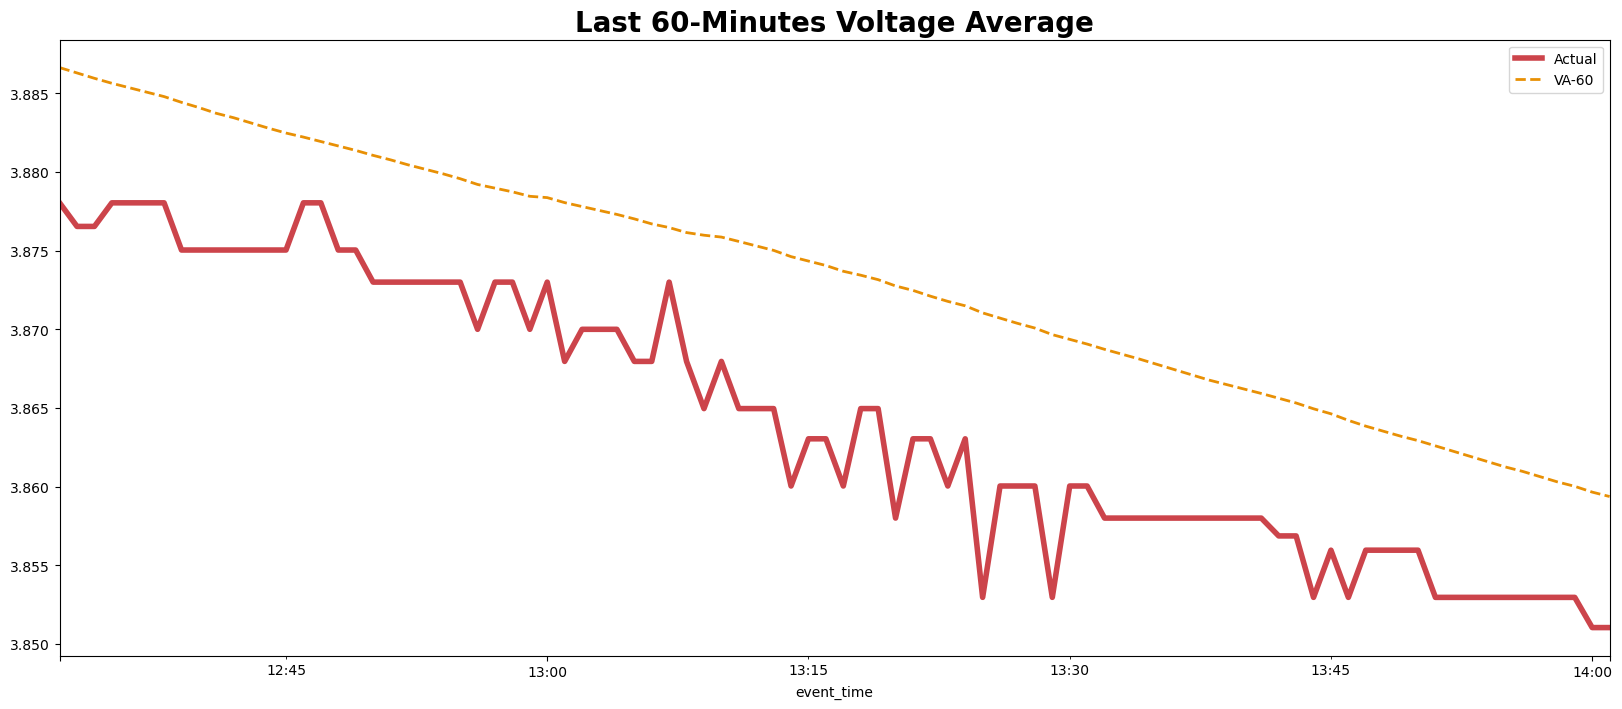

In [27]:
voltage_average(va, 60)

In [33]:
def soc_average(data, window):
    actual = data['soc'][-(window+30):]
    va = data['soc'].rolling(window).mean()[-(window+30):]
    
    plt.figure(figsize=(20,8))
    actual.plot(label='Actual', lw=4)
    va.plot(label='SA-{}'.format(str(window)), ls='--', lw=2)
    plt.title('Last {}-Minutes SoC Average'.format(str(window)), weight='bold', fontsize=20)
    plt.legend()

In [28]:
# soc_average(sa, 60)

### Train / Test Split

In [29]:
df_train, df_test = va[va.index < '2024-11-06'], va[va.index >= '2024-11-06']

print('Train:\t', len(df_train))
print('Test:\t', len(df_test))

Train:	 4946
Test:	 842


In [30]:
# df_train, df_test = sa[sa.index < '2024-11-06'], sa[sa.index >= '2024-11-06']

# print('Train:\t', len(df_train))
# print('Test:\t', len(df_test))

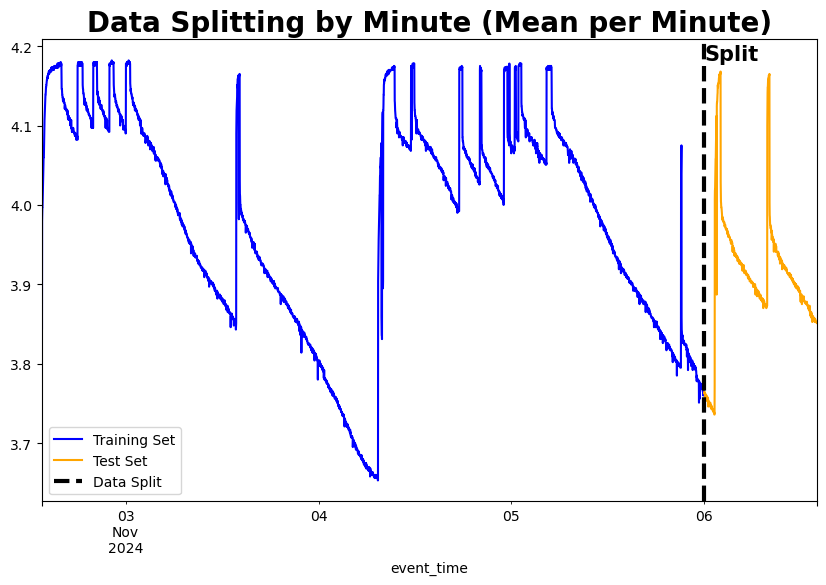

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(10, 6))

df_train['vol'].plot(label='Training Set', color='blue')
df_test['vol'].plot(label='Test Set', color='orange')

split_date = pd.to_datetime('2024-11-05 23:59:59')
plt.axvline(split_date, color='black', ls='--', lw=3, label='Data Split')

plt.text(split_date, df_train['vol'].max(), 'Split', fontsize=15, fontweight='bold')

plt.xlim(df_train.index.min(), df_test.index.max())

plt.title('Data Splitting by Minute (Mean per Minute)', weight='bold', fontsize=20)
plt.legend(loc='best')  

plt.show()


In [32]:
# import matplotlib.pyplot as plt
# import pandas as pd

# plt.figure(figsize=(10, 6))

# df_train['soc'].plot(label='Training Set', color='blue')
# df_test['soc'].plot(label='Test Set', color='orange')

# split_date = pd.to_datetime('2024-11-05 23:59:59')
# plt.axvline(split_date, color='black', ls='--', lw=3, label='Data Split')

# plt.text(split_date, df_train['soc'].max(), 'Split', fontsize=15, fontweight='bold')

# plt.xlim(df_train.index.min(), df_test.index.max())

# plt.title('Data Splitting by Minute (Mean per Minute)', weight='bold', fontsize=20)
# plt.legend(loc='best')  

# plt.show()


In [33]:
df_train.index.min(), df_train.index.max()

(Timestamp('2024-11-02 13:34:00'), Timestamp('2024-11-05 23:59:00'))

In [34]:
df_test.index.min(), df_test.index.max()

(Timestamp('2024-11-06 00:00:00'), Timestamp('2024-11-06 14:01:00'))

## Building Models

### 1. Prophet

Prophet is an open-source library for univariate (one variable) time series forecasting developed by Facebook. It works best with time series that have strong seasonal effects and several seasons of historical data

Official Documentation: [Here](facebook.github.io/prophet/#:~:text=Prophet%20is%20a%20procedure%20for,several%20seasons%20of%20historical%20data.)

Helpful Resources:
 - https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/
 - https://www.kaggle.com/code/prashant111/tutorial-time-series-forecasting-with-prophet/notebook

In [35]:
def index_to_column(data):
    data = data.reset_index()
    data['Datetime'] = pd.to_datetime(data['event_time'])
    data = data.sort_values('event_time')
    
    data = data.rename(columns={'event_time': 'ds', 'vol': 'y'})[['ds', 'y']]
    return data

In [36]:
# def index_to_column(data):
#     data = data.reset_index()
#     data['Datetime'] = pd.to_datetime(data['event_time'])
#     data = data.sort_values('event_time')
    
#     data = data.rename(columns={'event_time': 'ds', 'soc': 'y'})[['ds', 'y']]
#     return data

In [37]:
prophet_train = index_to_column(df_train)
prophet_test = index_to_column(df_test)

In [38]:
prophet_train.head()

,ds,y
0,2024-11-02 13:34:00,3.96000
1,2024-11-02 13:35:00,3.84304
2,2024-11-02 13:36:00,3.98004
3,2024-11-02 13:37:00,3.99000
4,2024-11-02 13:38:00,3.99696


In [39]:
prophet_train.isna().sum(), prophet_test.isna().sum()

(ds    0
 y     0
 dtype: int64,
 ds    0
 y     0
 dtype: int64)

In [46]:
!pip install prophet

  Using cached prophet-1.1.6-py3-none-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.5 kB)
  Using cached cmdstanpy-1.2.4-py3-none-any.whl.metadata (4.1 kB)
  Using cached holidays-0.60-py3-none-any.whl.metadata (25 kB)
  Using cached stanio-0.5.1-py3-none-any.whl.metadata (1.6 kB)
Using cached prophet-1.1.6-py3-none-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (14.4 MB)
Using cached cmdstanpy-1.2.4-py3-none-any.whl (94 kB)
Using cached holidays-0.60-py3-none-any.whl (1.1 MB)
Using cached stanio-0.5.1-py3-none-any.whl (8.1 kB)


In [40]:
from prophet import Prophet

prophet_model = Prophet(interval_width=0.95)

prophet_model.fit(prophet_train)
prophet_pred = prophet_model.predict(prophet_test[['ds']])

Importing plotly failed. Interactive plots will not work.
14:24:55 - cmdstanpy - INFO - Chain [1] start processing
14:24:56 - cmdstanpy - INFO - Chain [1] done processing


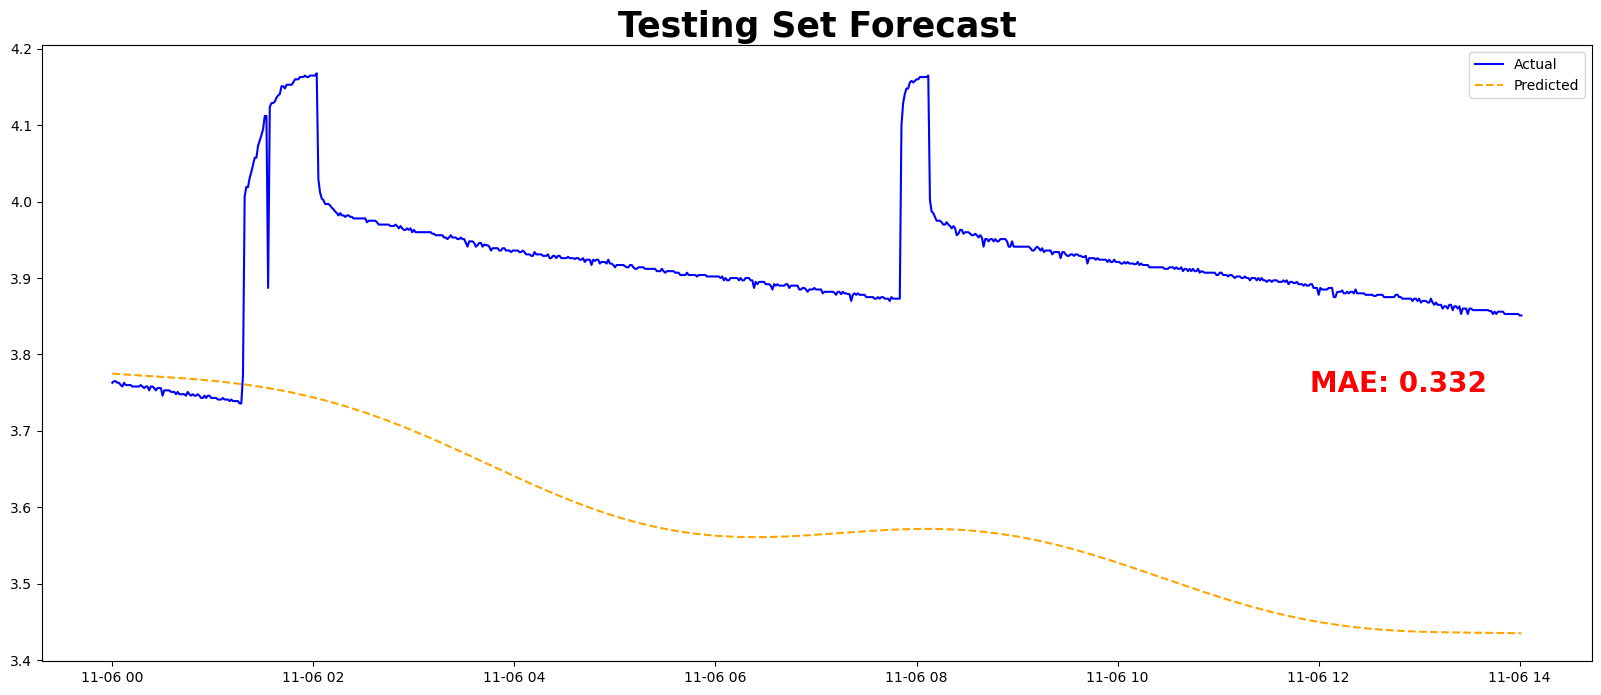

In [41]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

mae = round(mean_absolute_error(prophet_test['y'], prophet_pred['yhat']), 3)

plt.figure(figsize=(20, 8))
plt.plot(prophet_test['ds'], prophet_test['y'], label='Actual', color='blue')
plt.plot(prophet_pred['ds'], prophet_pred['yhat'], label='Predicted', color='orange', linestyle='--')

mae_x = prophet_test['ds'].iloc[int(len(prophet_test) * 0.85)]  # ~85% of the way through the test data
mae_y = prophet_test['y'].max() * 0.9  # Slightly below max y for visibility

plt.text(mae_x, mae_y, f'MAE: {mae}', fontsize=20, color='red', fontweight='bold')

# Title and legend
plt.title('Testing Set Forecast', weight='bold', fontsize=25)
plt.legend()
plt.show()


In [42]:
new_df = index_to_column(df)

In [43]:
prophet_model2 = Prophet(interval_width=0.95)
prophet_model2.fit(new_df)

future_dates = prophet_model2.make_future_dataframe(periods=120, freq='T')
prophet_pred2 = prophet_model2.predict(future_dates)

14:26:13 - cmdstanpy - INFO - Chain [1] start processing
14:26:37 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 2000x800 with 0 Axes>

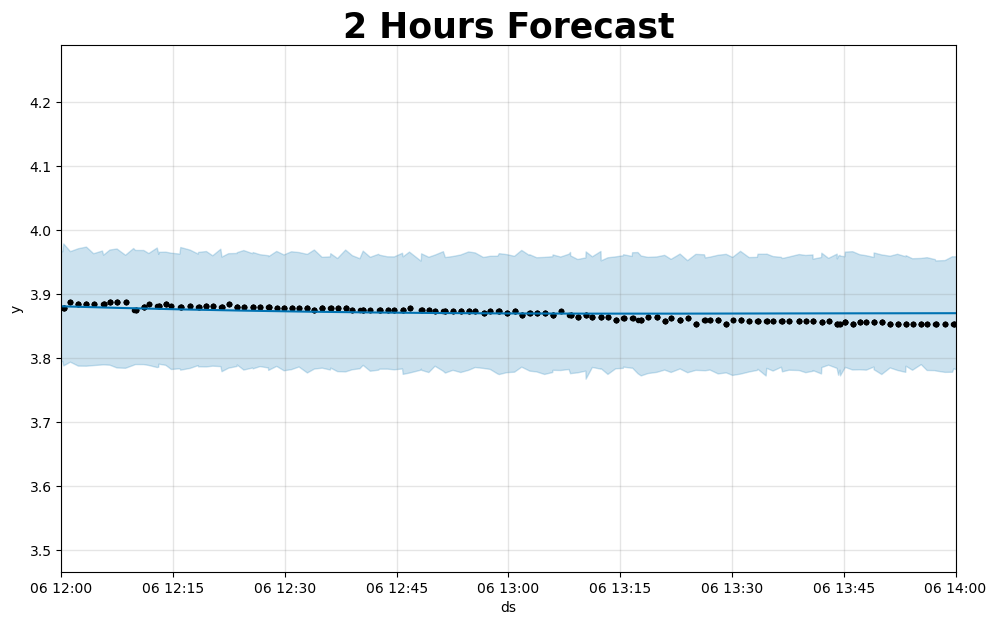

In [44]:
plt.figure(figsize=(20,8))

fig = prophet_model2.plot(prophet_pred2, uncertainty=True)
ax = fig.gca()
ax.set_xlim(pd.to_datetime(['2024-11-06 12:00', '2024-11-06 14:00']))
plt.title('2 Hours Forecast', weight='bold', fontsize=25)
plt.show()

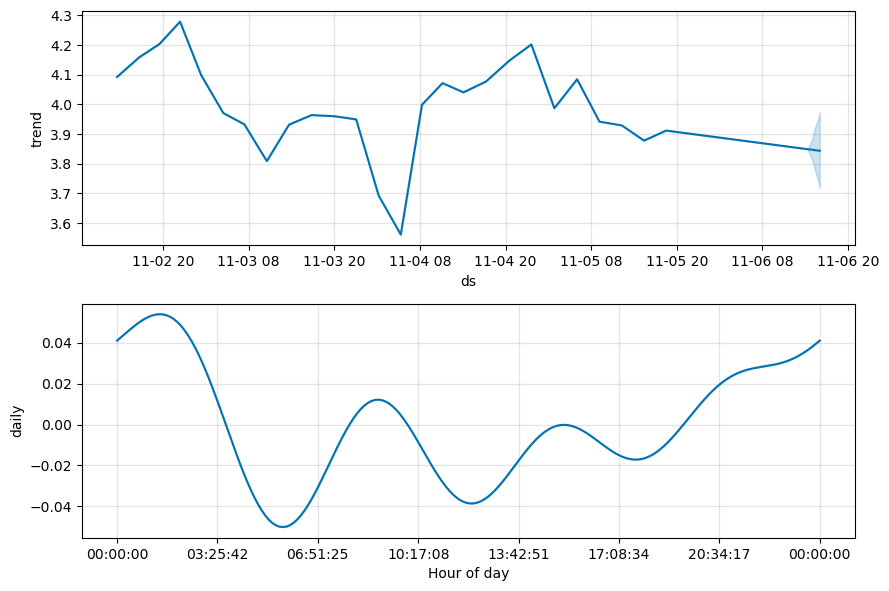

In [45]:
prophet_model.plot_components(prophet_pred2)
plt.show()

<Figure size 2000x800 with 0 Axes>

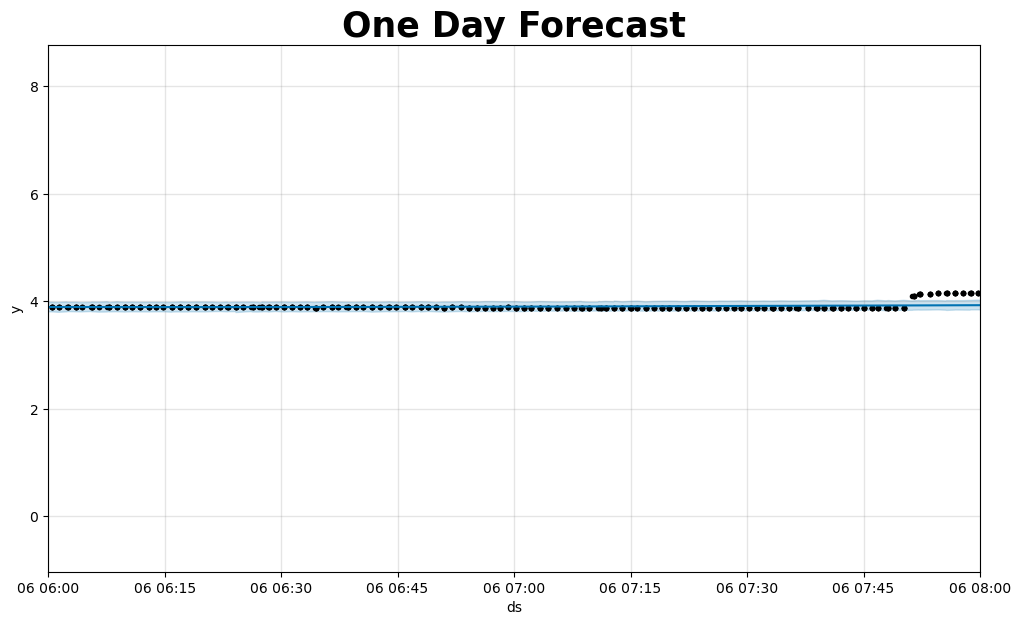

In [46]:
future_dates2 = prophet_model2.make_future_dataframe(periods=24, freq='H')
prophet_pred3 = prophet_model2.predict(future_dates2)

plt.figure(figsize=(20,8))

fig = prophet_model2.plot(prophet_pred3, uncertainty=True)
ax = fig.gca()
ax.set_xlim(pd.to_datetime(['2024-11-06 06:00', '2024-11-06 08:00']))
plt.title('One Day Forecast', weight='bold', fontsize=25)
plt.show()

## 2. XGBoost

XGBoost is short for Extreme Gradient Boosting and is an efficient implementation of the stochastic gradient boosting machine learning algorithm

The stochastic gradient boosting algorithm, also called gradient boosting machines or tree boosting, is a powerful machine learning technique that performs well or even best on a wide range of challenging machine learning problems

To be able to use XGBoost for time series forecasting, the data should be transformed into supervised learning before feeding it into the model

Official Documentation: [Here](https://xgboost.readthedocs.io/en/stable/python/python_api.html)

Helpful Resources:

 - https://machinelearningmastery.com/xgboost-for-time-series-forecasting/
 - https://www.kaggle.com/code/robikscube/tutorial-time-series-forecasting-with-xgboost


In [54]:
def date_transform(data):
    df = data.copy()
    
    df['Hour'] = df.index.hour
    df['Dayofweek'] = df.index.dayofweek
    df['Dayofmonth'] = df.index.day
    df['Dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week 
    df['Month'] = df.index.month
    df['Quarter'] = df.index.quarter
    df['Year'] = df.index.year
    
    X = df.drop('vol', axis=1) 
    y = df['vol']              
    
    return X, y


In [58]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 8.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 11.1 MB/s eta 0:00:0000:0100:01


In [1]:
import datetime
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

In [2]:
X_train, y_train = date_transform(df_train)
X_test, y_test = date_transform(df_test)

NameError: name 'date_transform' is not defined

In [64]:
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, early_stopping_rounds=10)
xgb_model.fit(X_train, y_train, eval_metric='mae', eval_set=[(X_train, y_train), (X_test, y_test)])
xgb_pred = xgb_model.predict(X_test)

TypeError: XGBModel.fit() got an unexpected keyword argument 'eval_metric'

In [68]:
xgb_model = XGBRegressor(
    n_estimators=1000, 
    learning_rate=0.05,
    objective='reg:squarederror',  # Regression objective
    eval_metric='mae'
)

xgb_model.fit(
    X_train, 
    y_train, 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    early_stopping_rounds=10, 
    verbose=True,  # Prints progress during training
)
xgb_pred = xgb_model.predict(X_test)


TypeError: XGBModel.fit() got an unexpected keyword argument 'early_stopping_rounds'

#### 1. Time Series Cross Validation

### 3. Lag Features

What was the target (x) days in the past.


Retraining on all data

To Predict the future we need an emtpy dataframe for future date ranges.

Run those dates through our feature creation code + lag creation

### Predict the future